# Описание сборного проекта 1

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**Цель исследования** — нужно выявить определяющие успешность игры закономерности. 

**Ход исследования**

Данные об играх получены из файла `games.csv`. О качестве данных ничего не известно, поэтому перед анализом понадобится обзор данных. 
 
Таким образом, исследование пройдёт в пять этапов:
 1. Обзор данных.
 2. Предобработка данных.
 3. Исследовательский анализ.
 4. Категоризация пользователей по регионам.
 5. Проверка гипотез

## 1 Обзор данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
from scipy import stats as st

# подгружаем необходимые библиотеки и модули

In [2]:
data = pd.read_csv('/datasets/games.csv') # открываем файл

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод:** 
Данные состоят из 11 столбцов и 16715 строк, но видно что эти данные ещё не обработаны.
* нужно переименовать названия столбцов, изменив их на нижний регистр.
* обработать пропуски в `name`, `year_of_release`, `genre`, `critic_score`, `user_score`, `rating`.
* изменить типы данных в столбцах, если потребуется.

## 2 Предобработка данных

### 2.1 Смена регистра

Начнём предобработку со смены регистра в названиях столбцов.

In [5]:
data.columns = data.columns.str.lower() # меняем регистр
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### 2.2 Обработка пропусков

В столбцах успешно сменён регистр. Теперь пора взглянуть на пропуски.

In [6]:
data.duplicated().sum() # проверяем датасет на предмет явных дубликатов.

0

In [7]:
data['name'].isna().sum()

2

Данные об этих безымянных играх можно удалить, так как они составляют малую долю от общего количества.b

In [8]:
data = data.dropna(subset = ['name'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Вместе с удалением пропусков в названиях игр исчезло по 2 пропуска из столбцов с годом выхода и жанром игры.
Далее рассмотрим остальные столбцы.

In [9]:
data['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

In [10]:
data = data.dropna(subset = ['year_of_release'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [11]:
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [12]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Видим в столбце значения TBD - to be determined. Заменим эти значения на пропуски.

In [13]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [14]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [15]:
data['rating'] = data['rating'].fillna('Not Rated')

In [16]:
data['rating'].value_counts()

Not Rated    6676
E            3921
T            2905
M            1536
E10+         1393
EC              8
K-A             3
RP              1
AO              1
Name: rating, dtype: int64

### 2.3 Заменяем типы данных

Необходимо заменить тип столбца `year_of_release` на целочисленный, годы не могут быть дробными.
Заменить тип `user_score` на вещественный, так как мы избавились от значений 'tbd'.

In [17]:
data['year_of_release'] = data['year_of_release'].astype(int)
data['user_score'] = data['user_score'].astype(float)

### 2.4 Добавляем новый столбец

In [18]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data['total_sales']

0        82.54
1        40.24
2        35.52
3        32.77
4        31.38
         ...  
16710     0.01
16711     0.01
16712     0.01
16713     0.01
16714     0.01
Name: total_sales, Length: 16444, dtype: float64

**Вывод:** были произведены обработка пропусков, замена типов данных и добавление столбца. В столбцах `rating`, `critic_score`, `user_score` осталось много пропусков (скорее всего, это новые игры, которые ещё не успели оценить), но их нельзя заменить медианой или средним значением. Удалить их также нельзя, так как они составляют немалую часть данных.

## 3 Проведите исследовательский анализ

### 3.1 Исследование популярных платформ и вычисление актуального временного периода

**Количество игр по годам**

Посмотрим, сколько игр выпускалось в разные годы, построив линейный график.

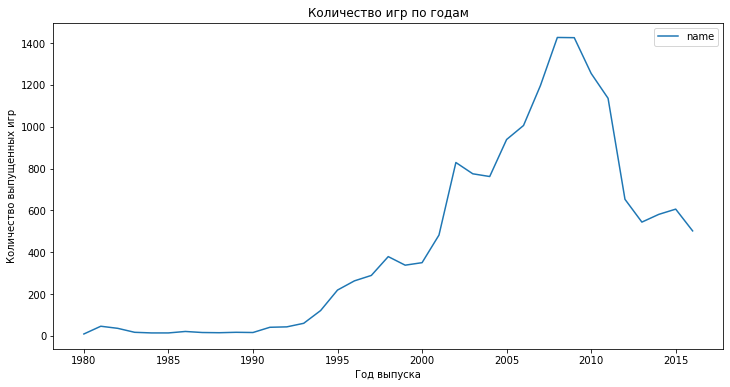

In [20]:
games_by_each_year = data.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count') # строим сводную таблицу

plt.figure(figsize = (12, 6))
sns.lineplot(data = games_by_each_year)
plt.title("Количество игр по годам")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")
plt.show()

In [21]:
data.year_of_release.value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: year_of_release, dtype: int64

Из диграммы видно, что в середине 90-ых начался рост выпуска игр для компьютеров и консолей. Это рост стабильно продолжался до 2008-2009 годов, а затем данный показатель и вовсе пошёл на спад. Возможно, это связано с популярностью игр на мобильные телефоны.

**Количество продаж игр по платформам**

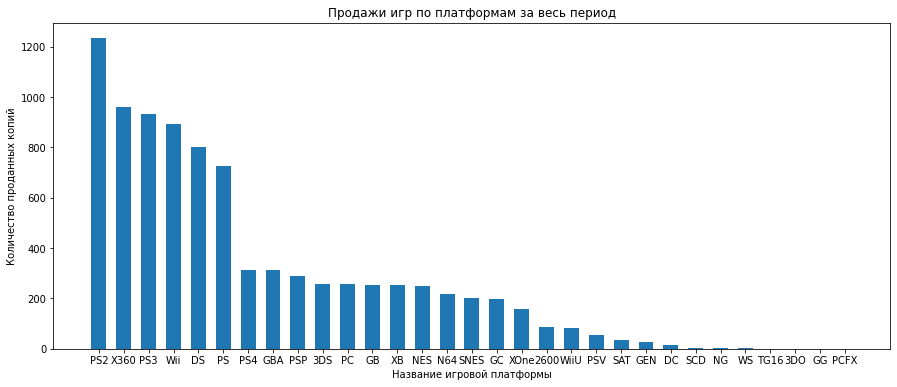

In [22]:
sales_by_platform = data.pivot_table(index = 'platform',
                                      values = 'total_sales',
                                      aggfunc = 'sum').sort_values('total_sales', ascending = False) 
# строим сводную таблицу

plt.figure(figsize = (15, 6))

plt.bar(sales_by_platform.index, sales_by_platform['total_sales'], width = 0.6)

plt.title("Продажи игр по платформам за весь период")
plt.xlabel("Название игровой платформы")
plt.ylabel("Количество проданных копий")
plt.show()

Видно, что самыми популярными платформами по количеству продаж игр на них являются PlayStation 2, Xbox 360, PlayStation 3, Nintendo Wii и Nintendo DS. Но не следует торопиться с выбором этих платформ как потенциально прибыльных, так как мы ещё не определились с нужными нам показателями, которые определяют потенциальную прибыльность платформы.

<AxesSubplot:xlabel='year_of_release'>

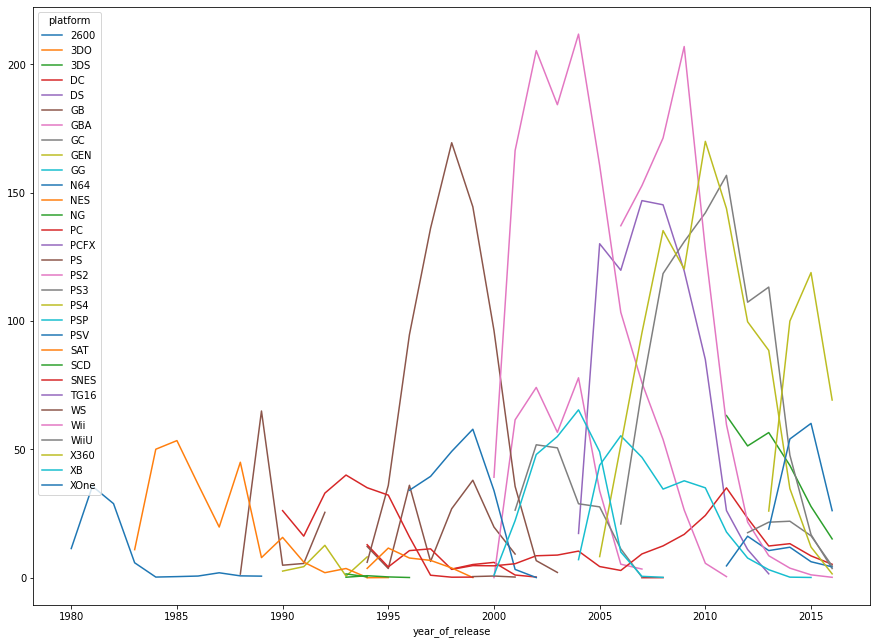

In [23]:
data.pivot_table(index = 'year_of_release',
                 columns = 'platform',
                 values = 'total_sales',
                 aggfunc = 'sum').plot(figsize = (15, 11))

Далее создадим сводную таблицу для десяти самым популярным платформ по продажам игр.

In [24]:
platforms_ascending = data.pivot_table(index = 'platform',
                                       values = 'total_sales',
                                       aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False) 
# создаём таблицу с популярными платформами в плане продажи игр в порядке убывания

platforms = platforms_ascending.reset_index()
iloc_top10_platforms = platforms.iloc[0:10] # обрезаем таблицу, оставляя 10 элементов.
top10_platforms = iloc_top10_platforms['platform'].unique() # оставляем неповторяю

In [25]:
platforms_ascending # выведем на экран для проверки

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Представим данные о продажах по годам на самых популярных платформах-консолях в виде графика

<AxesSubplot:xlabel='year_of_release'>

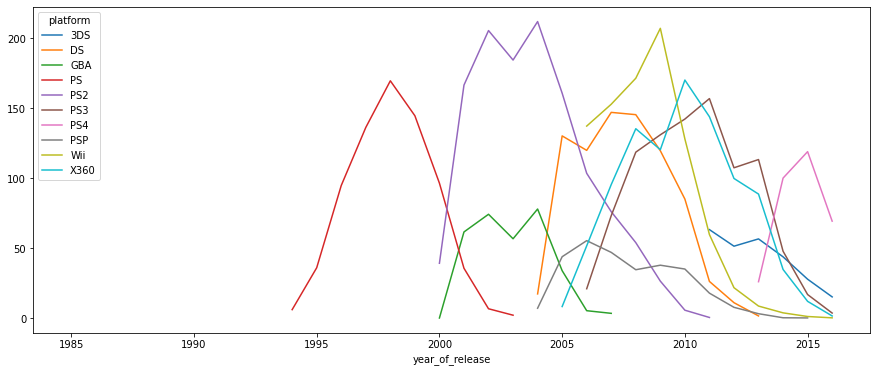

In [26]:
data.query('platform in @top10_platforms').pivot_table(index = 'year_of_release',
                                                       columns = 'platform', 
                                                       values = 'total_sales',
                                                       aggfunc = 'sum').plot(figsize = (15, 6))

Из этого графика можно сделать несколько выводов:
* средний жизненный цикл консоли, как можно судить по линиям PS3 и Xbox 360 из этого графика, составляет 10 лет.
* в среднем, консоль достигает пика жизненного цикла (когда на консоль выходит максимальное количество игр в год) примерно в его середине, а именно - спустя 5 лет после выхода.
* в период с 2006 по 2016 две самые популярные консоли в плане продаж игр - PS3 и Xbox 360.

Так как нам необходимо сделать прогнозы на 2017 год, то нужно выбрать в качестве кандидатов на потенциально прибыльные платформы те консоли, которые вышли относительно недавно (не позже 2013 года), либо всегда демонстрировали небольшие, но стабильные продажи.
К таким устройствам можно отнести PS4 и PC.

In [27]:
actual_data = data.query('year_of_release >= 2013')

In [28]:
actual_platforms = ['PS4', 'PC']

**Построение "ящика с усами"**

<AxesSubplot:>

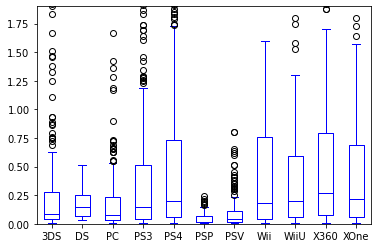

In [29]:
actual_data.pivot_table(index = 'name',
                        columns = 'platform',
                        values = 'total_sales',
                        aggfunc = 'sum').plot(kind = 'box', ylim = (0, 1.9), color = 'blue')

<AxesSubplot:>

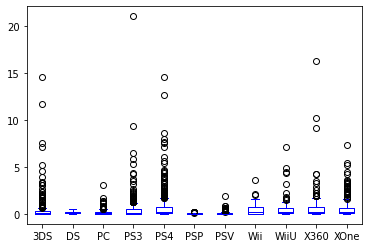

In [30]:
actual_data.pivot_table(index = 'name',
                        columns = 'platform',
                        values = 'total_sales',
                        aggfunc = 'sum').plot(kind = 'box', color = 'blue')

Заметим, что у консоли Wii слишком большие выбросы.

Из этих диаграмм видно, что в нашу выборку актуальных платформ можно добавить Xbox One и Wii U. Их не было в предыдущем графике по той причине, что эти две консоли вышли относительно недавно, поэтому они не входят в топ-10 по продажам игр. Под эти платформы даже не нужно изменять рамки актуального периода, так как Xbox One и Wii вышли позже 2012 года.

In [31]:
actual_platforms.append('XOne')
actual_platforms.append('WiiU')

In [32]:
print(actual_platforms)

['PS4', 'PC', 'XOne', 'WiiU']


### 3.2 Нахождение зависимости между отзывами и продажами игр

**Корреляция между отзывами и продажами игр**

Посмотрим, как влияют отзывы пользователей и критиков в рамках одной платформы - например, PlayStation 4. Вычислим корреляцию и построим диаграммы рассеивания для этой платформы.

In [33]:
ps4_data = actual_data[actual_data['platform'] == 'PS4']

print('Корреляция между оценками пользователей и продажами:', ps4_data['user_score'].corr(ps4_data['total_sales']))
print('Корреляция между оценками критиков и продажами: ', ps4_data['critic_score'].corr(ps4_data['total_sales']))

Корреляция между оценками пользователей и продажами: -0.031957110204556376
Корреляция между оценками критиков и продажами:  0.40656790206178095


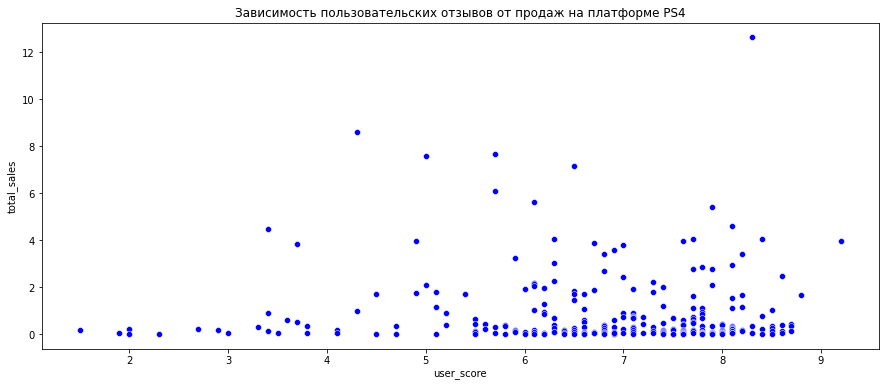

In [34]:
plt.figure(figsize = (15, 6))

sns.scatterplot(x = 'user_score', y = 'total_sales', data = ps4_data, color = 'Blue')
plt.title('Зависимость пользовательских отзывов от продаж на платформе PS4')
plt.show()

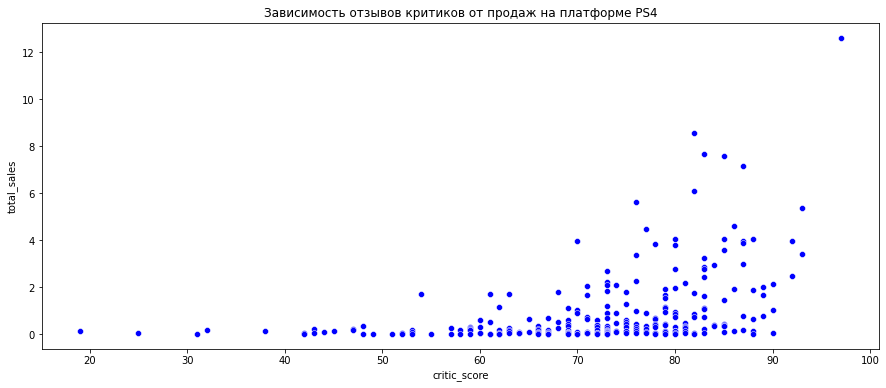

In [35]:
plt.figure(figsize = (15, 6))
sns.scatterplot(x = 'critic_score', y = 'total_sales', data = ps4_data, color = 'Blue')
plt.title('Зависимость отзывов критиков от продаж на платформе PS4')
plt.show()

Видно, что связь между оценками пользователей и продажами игр на PS4 отсутствует. При этом наблюдается умеренная связь между оценками критиков и продажами игр на PS4. Это значит, что чем выше игра оценена критиками, тем слегка больше будут продажи игр.

In [36]:
data.year_of_release.min()

1980

Проведём аналогичное исследование для других актуальных платформ: XOne, Wii U и PC.

In [38]:
def platform_info(platform_name):
    platform = actual_data[actual_data['platform'] == platform_name]
    # функция для построения графиков размаха и подсчёта корреляций.

    plt.figure(figsize = (15, 6))
    
    sns.scatterplot(x = 'user_score', y = 'total_sales', data = platform, color = 'Blue')
    plt.title('Зависимость пользовательских отзывов от продаж на платформе ' + platform_name)
    plt.show()

    plt.clf
    
    plt.figure(figsize = (15, 6))
    sns.scatterplot(x = 'critic_score', y = 'total_sales', data = platform, color = 'Blue')
    plt.title('Зависимость отзывов критиков от продаж на платформе ' + platform_name)
    plt.show()
    
    print('Корреляция между оценками пользователей и продажами',
          platform_name, 'равна:',
          platform['user_score'].corr(platform['total_sales']))
    print('Корреляция между оценками критиков и продажами',
          platform_name, 'равна:',
          platform['critic_score'].corr(platform['total_sales']))
    

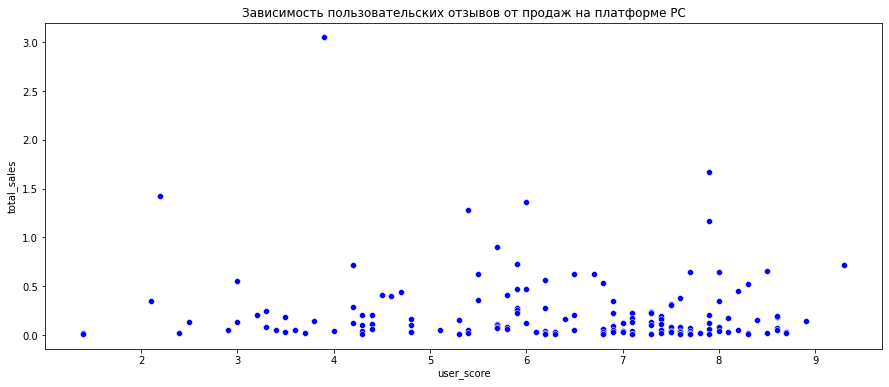

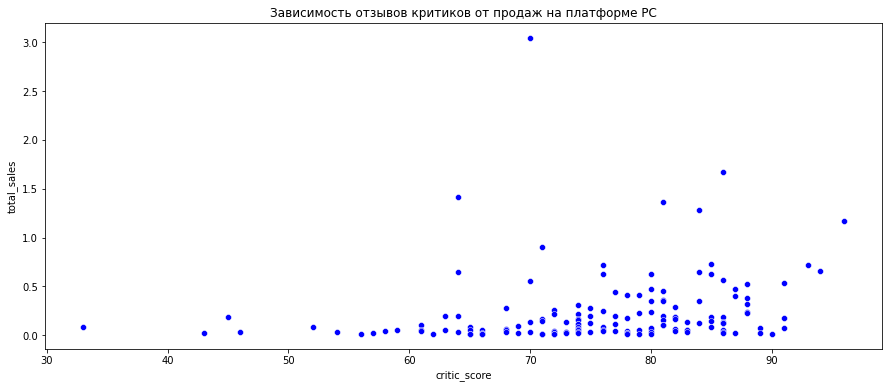

Корреляция между оценками пользователей и продажами PC равна: -0.0938418695247674
Корреляция между оценками критиков и продажами PC равна: 0.19603028294369382


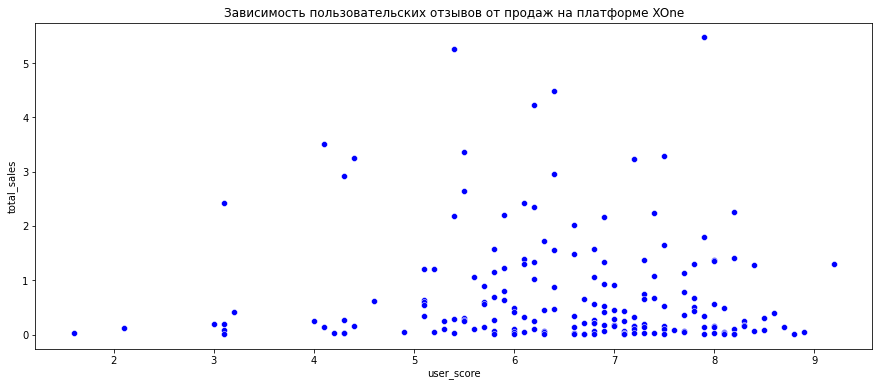

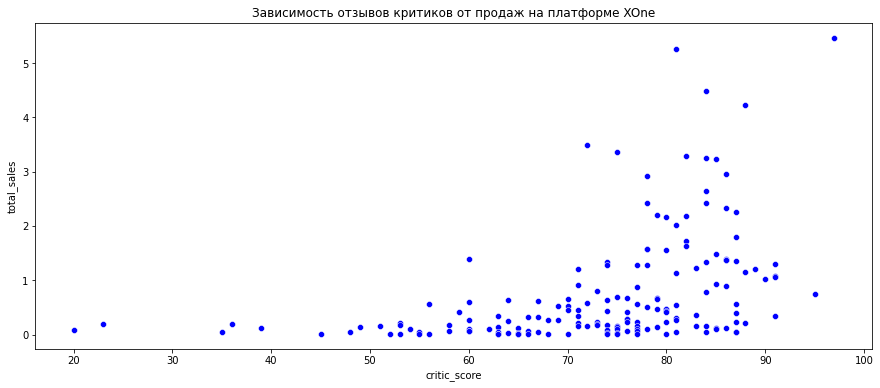

Корреляция между оценками пользователей и продажами XOne равна: -0.06892505328279414
Корреляция между оценками критиков и продажами XOne равна: 0.4169983280084017


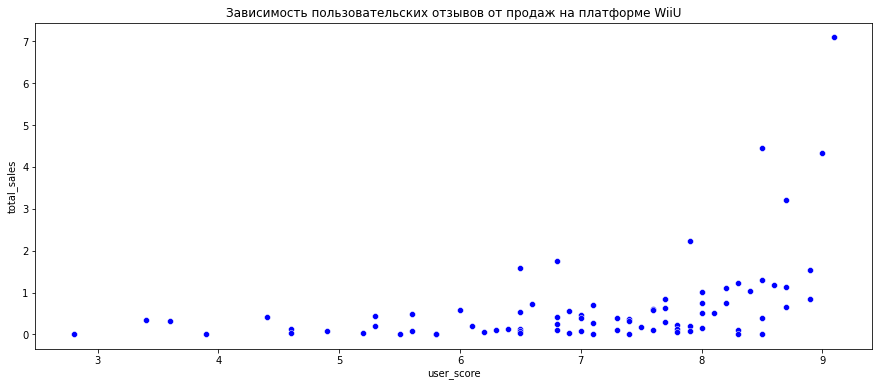

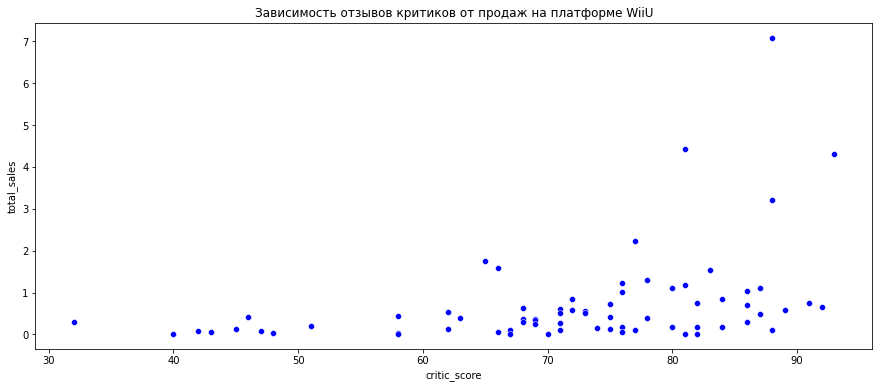

Корреляция между оценками пользователей и продажами WiiU равна: 0.4193304819266187
Корреляция между оценками критиков и продажами WiiU равна: 0.3764149065423912


In [39]:
for platform_name in actual_platforms: # проходимся по каждой платформе кроме PS4
    if platform_name != "PS4":
        platform_info(platform_name)

Почти на каждой из актуальных платформ есть умеренная связь между оценкой критиков и продажами игр. Но есть исключение из этого правила - платформа ПК, на которой связь между оценкой критиков и продажами игр - слабая. При этом связь между оценкой пользователей и продажами наблюдается только на WiiU среди тех платформ, которые мы рассматривали.

In [40]:
actual_platforms, actual_data.platform.unique()

(['PS4', 'PC', 'XOne', 'WiiU'],
 array(['PS3', 'X360', 'PS4', '3DS', 'XOne', 'WiiU', 'Wii', 'PC', 'PSV',
        'DS', 'PSP'], dtype=object))

### 3.3 Выявление самых популярных жанров

**Посмотрим на общее распределение игр по жанрам**

Рассмотрим общие продажи для данных, сгруппированных по жанрам, и для наглядности построим круговую диаграмму.

Посмотрим на медианные значения.

In [42]:
actual_data.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'median').sort_values('total_sales', ascending = False)

,total_sales
genre,
Shooter,0.450
Sports,0.240
Platform,0.225
Role-Playing,0.125
Fighting,0.125
Racing,0.120
Action,0.110
Simulation,0.100
Misc,0.100


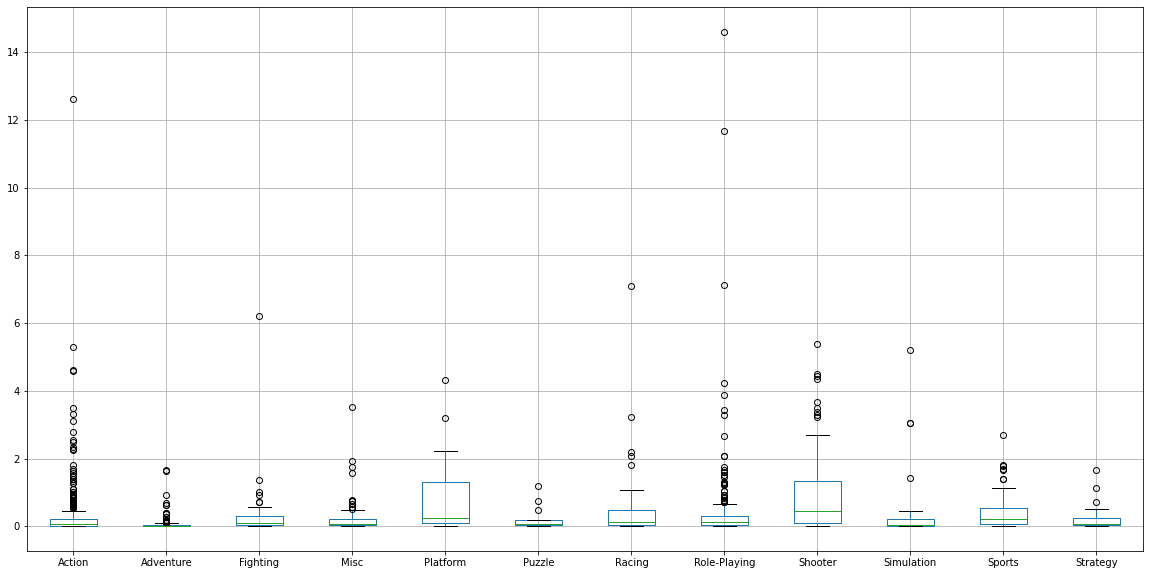

In [43]:
plt.figure(figsize = (20, 10))


genre_data = actual_data.pivot_table(index = 'name',
                                     columns = 'genre',
                                     values = 'total_sales',
                                     aggfunc = 'median')

bp_genre = genre_data.boxplot()

Рассмотрим данные на круговой диаграмме для формирования дополнительных выводов.

<AxesSubplot:ylabel='total_sales'>

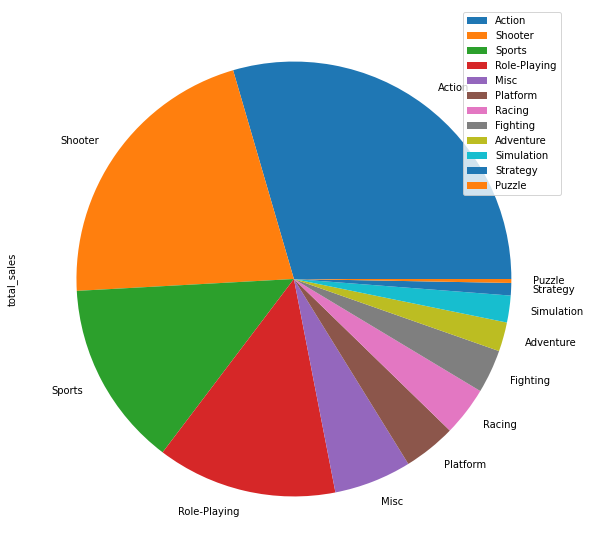

In [44]:
actual_data.pivot_table(index = 'genre', 
                        values = 'total_sales',
                        aggfunc = 'sum').sort_values(ascending = False,
                                                     by = 'total_sales').plot(kind = 'pie',
                                                                              figsize = (10, 10),
                                                                              y = 'total_sales')

По медианным значениям можно сделать вывод, что самыми прибыльными жанрами вне зависимости от платформы являются шутеры, платформеры и спортивные игры. Также стоит отметить, что такие жанры как РПГ и экшен-игры имеют большое количество разбросов при высокой медиане. Скорее всего, это обусловлено тем, что в этих жанрах выходит много как прибыльных игр, так и убыточных. Именно из-за этого общие продажи некоторых жанров - экшен, РПГ такие большие, хотя сами эти жанры сами по себе не являются прибыльными.

**Прибыльными жанрами следует считать шутеры, платформеры и спортивные игры.**

**Вывод:** в результате исследовательского анализа данных были выявлены следующие закономерности:
* число игр на игровые приставки и компьютеры начало стремительно расти с большой скоростью с 90-ых годов до 2009 года. С 2009 года произошел резкий спад выпускаемых на эти игровые платформы игр. Возможно, это связано с выросшей популярностью мобильных платформ и выбором разработчиков в их пользу.
* жизненный цикл консолей равен 10 лет, пик приходится на отметку в 5 лет.
* самые популярные игровые платформы за весь период: PlayStation 2, Xbox 360, Playstation 3, Nintendo WII, Nintendo DS.
* для многих игровых платформ наблюдается взаимосвязь между продажами игр и оценками игр. Больше всего заметна корреляция между оценками критиков и продажами - значит, для игроков мнение критиков важнее мнения других пользователей.
* самые популярные жанры - платформеры, спортивные игры и шутеры.

В качестве актуальных платформ были выбраны PS4, Xbox One, Wii U и PC.

In [45]:
actual_data['rating'].value_counts()

Not Rated    977
M            369
T            333
E            302
E10+         252
Name: rating, dtype: int64

## 4 Составление портрета пользователя каждого региона (NA, EU, JP)

### 4.1 Самые популярные платформы

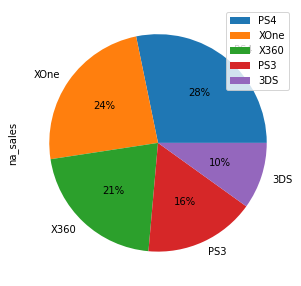

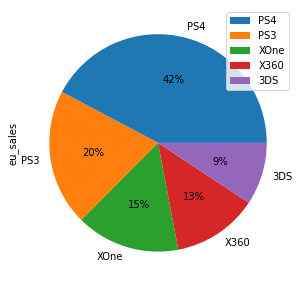

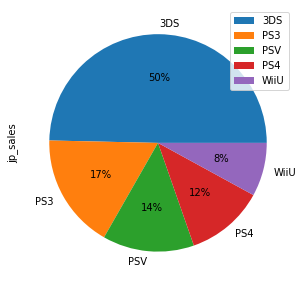

In [46]:
actual_data.pivot_table(index = 'platform', 
                        values = 'na_sales',
                        aggfunc = 'sum').sort_values(by = 'na_sales',
                                                     ascending = False).head().plot(kind = 'pie',
                                                                                    figsize = (5, 5),
                                                                                    y = 'na_sales',
                                                                                    autopct='%.0f%%');

actual_data.pivot_table(index = 'platform', 
                        values = 'eu_sales',
                        aggfunc = 'sum').sort_values(by = 'eu_sales',
                                                     ascending = False).head().plot(kind = 'pie',
                                                                                    figsize = (5, 5),
                                                                                    y = 'eu_sales',
                                                                                    autopct='%.0f%%');


actual_data.pivot_table(index = 'platform', 
                        values = 'jp_sales',
                        aggfunc = 'sum').sort_values(by = 'jp_sales',
                                                     ascending = False).head().plot(kind = 'pie', 
                                                                                    figsize = (5, 5),
                                                                                    y = 'jp_sales', 
                                                                                    autopct='%.0f%%');

**Вывод:** 
* в Северной Америке и Канаде популярными являются игры, проданные на PS4 и Xbox One.
* в Европе популярными являются игры, проданные на PS4.
* В Японии популярными являются игры, проданные на Nintendo 3DS.

### 4.2 Самые популярные жанры

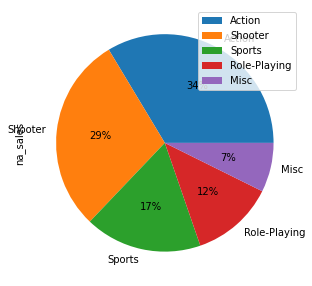

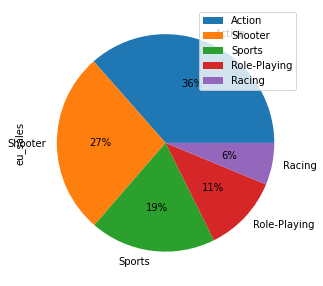

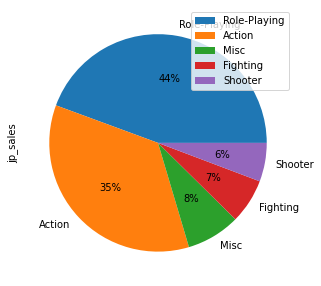

In [47]:
actual_data.pivot_table(index = 'genre', 
                        values = 'na_sales',
                        aggfunc = 'sum').sort_values(by = 'na_sales',
                                                     ascending = False).head().plot(kind = 'pie',
                                                                                    figsize = (5, 5),
                                                                                    y = 'na_sales',
                                                                                    autopct='%.0f%%');

actual_data.pivot_table(index = 'genre', 
                        values = 'eu_sales',
                        aggfunc = 'sum').sort_values(by = 'eu_sales',
                                                     ascending = False).head().plot(kind = 'pie',
                                                                                    figsize = (5, 5),
                                                                                    y = 'eu_sales',
                                                                                    autopct='%.0f%%');


actual_data.pivot_table(index = 'genre', 
                        values = 'jp_sales',
                        aggfunc = 'sum').sort_values(by = 'jp_sales',
                                                     ascending = False).head().plot(kind = 'pie', 
                                                                                    figsize = (5, 5),
                                                                                    y = 'jp_sales', 
                                                                                    autopct='%.0f%%');

**Вывод:** 
* в Северной Америке и Канаде популярными являются игры в жанрах экшен и шутер.
* в Европе популярными являются игры в жанрах экшен, шутер и спортивные игры.
* В Японии популярными являются игры в жанрах экшен и РПГ.

### 4.3 Рейтинг ESRB

<AxesSubplot:ylabel='jp_sales'>

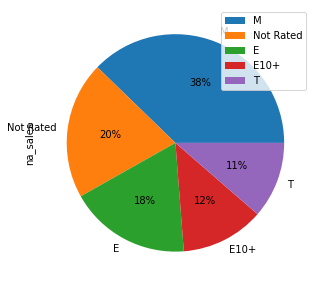

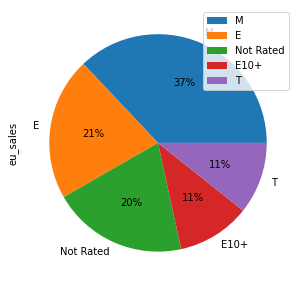

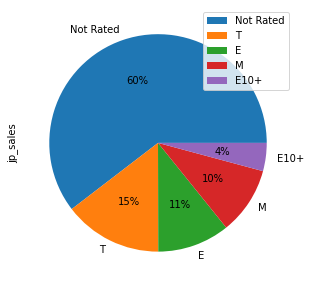

In [48]:
actual_data.pivot_table(index = 'rating', 
                        values = 'na_sales',
                        aggfunc = 'sum').sort_values(by = 'na_sales',
                                                     ascending = False).head().plot(kind = 'pie',
                                                                                    figsize = (5, 5),
                                                                                    y = 'na_sales',
                                                                                    autopct='%.0f%%')

actual_data.pivot_table(index = 'rating', 
                        values = 'eu_sales',
                        aggfunc = 'sum').sort_values(by = 'eu_sales',
                                                     ascending = False).head().plot(kind = 'pie',
                                                                                    figsize = (5, 5),
                                                                                    y = 'eu_sales',
                                                                                    autopct='%.0f%%')


actual_data.pivot_table(index = 'rating', 
                        values = 'jp_sales',
                        aggfunc = 'sum').sort_values(by = 'jp_sales',
                                                     ascending = False).head().plot(kind = 'pie', 
                                                                                    figsize = (5, 5),
                                                                                    y = 'jp_sales', 
                                                                                    autopct='%.0f%%')

In [49]:
temp = actual_data.copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts()

0 0.0


Not Rated    977
M            369
T            333
E            302
E10+         252
Name: rating, dtype: int64

**Вывод:** 
* в Северной Америке и Канаде популярными являются игры с возрастным ограничением "От 17 и выше".
* для игр из европейского и японского рейтинга ESRB не так сильно влияет на продажи, так как рейтинг ESRB назначается играм, выпущенным в Северной Америке и Канаде. В вышеупомянутых регионах существует собственное регулирование игр в плане возрастных ограничений.

## 5 Проверка гипотез

Нужно проверить две следующие гипотезы:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

### 5.1 Проверка гипотезы "средние пользовательские рейтинги платформ Xbox One и PC одинаковые"

In [50]:
xone_data = actual_data[actual_data['platform'] == 'XOne']['user_score']
xone_data = xone_data.dropna()
# создаём выборку для игр на Xbox One

pc_data = actual_data[actual_data['platform'] == 'PC']['user_score']
pc_data = pc_data.dropna()
# создаём аналогичную выборку для игр на ПК

print('Средний пользовательский рейтинг платформы Xbox One:', xone_data.mean())
print('Средний пользовательский рейтинг платформы PC', pc_data.mean())

Средний пользовательский рейтинг платформы Xbox One: 6.521428571428572
Средний пользовательский рейтинг платформы PC 6.2696774193548395


Сформулируем нулевую и альтернативную гипотезы:
* H0: Средние пользовательские рейтинги платформ Xbox One и PC равны.
* H1: Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

Нам нужно проверить двустороннюю гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, значит, воспользуемся методом `ttest_ind` библиотеки `scipy` для определения t-критерия.

In [51]:
# проверка первой гипотезы

alpha = .01

results = st.ttest_ind(xone_data, pc_data)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


Принимаем нулевую гипотезу: средние пользовательские рейтинги платформ Xbox One и PC равны.

### 5.2 Проверка гипотезы "средние пользовательские рейтинги жанров Action и Sports разные"

In [52]:
action_games = actual_data[actual_data['genre'] == 'Action']['user_score']
action_games = action_games.dropna()

sports_games = actual_data[actual_data['genre'] == 'Sports']['user_score']
sports_games = sports_games.dropna()

print('Средний пользовательский рейтинг жанра Action:', action_games.mean())
print('Средний пользовательский рейтинг жанра Sports', sports_games.mean())

Средний пользовательский рейтинг жанра Action: 6.837532133676092
Средний пользовательский рейтинг жанра Sports 5.238124999999999


Сформулируем нулевую и альтеративную гипотезы:
* H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые.
* H1: Средние пользовательские рейтинги жанров Action и Sports разные.

Применяем тот же метод, что и для первой двусторонней гипотезы.

In [53]:
# проверка второй гипотезы

alpha = .05 

results = st.ttest_ind(action_games, sports_games)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу и принимаем альтернативную гипотезу: средние пользовательские рейтинги жанров Action и Sports разные.

### Общий вывод

**Предобработка данных**
* был изменён регистр названий всех столбцов.
* были обработаны пропуски вида 'tbd' в столбце `user_score`.
* заменены типы некоторых столбцов на целочисленный.
* был добавлен новый столбец с общей суммой продаж по регионам.

**Исследовательский анализ данных**
* был обнаружен список самых популярных платформ за всё время - PS2, Xbox 360, PS3, Nintendo DS и Nintendo Wii.
* была обнаружена связь между оценками игр и их продажами. Чем выше оценка игры от критиков, тем слегка больше её продажи.
* был выявлен список самых популярных жанров - экшены, шутеры и платформеры.

**Портреты пользователей каждого региона за 2016-ый год**

***Игры, которые будут продаваться в Северной Америке лучше всего:***
* ESRB: "Для всех" и "От 17 и выше"
* Жанры: Шутеры и экшены
* Платформы: PS4, XOne

***Игры, которые будут продаваться в Европе лучше всего:***
* Жанры: Шутеры, спортивные игры и экшены
* Платформы: PS4, XOne

***Игры, которые будут продаваться в Японии лучше всего:***
* Жанры: РПГ и экшены
* Платформы: Wii U

**Проверка гипотез**

Результаты гипотез: 

Средние пользовательские рейтинги платформ Xbox One и PC равны. 

Средние пользовательские рейтинги жанров Action и Sports отличаются.

***В результате данного проекта были выявлены параметры игр, которые будут продаваться лучше всего, и на которые следует потратить рекламный бюджет интернет-магазина "Стримчик".***

***Самыми популярными будут игры в жанре экшен или шутер, выпущенные на платформы PS4 или Xbox One, с возрастным ограничением "От 17 и выше" и рекламой в североамериканском регионе. Также стоит обратить внимание на оценки игры, выставленные критиками: чем они выше, тем слегка будут выше продажи!***